# Multi-armed bandits

In this task you are going to implement ETC and UCB. Then you will play around the parameters in order to draw some more conclusion.

Outline:
* Simulator writing
* ETC and experiments
* UCB and experiments

## Bulding a simulator for the bandit

In [1]:
from matplotlib import pyplot as plt
import numpy as np  # we can use this library for working with matrices

In [2]:
class Bandit:
    def __init__(self, k, means, rounds):
        # we assume Gaussian distributions with sigma=1
        self.k = k  # number of arms
        self.means = means   # List of means, one mean for each arm
        self.rounds = rounds  # number of available rounds
        
        # ----- chose the optimal reward -----
        self.optimal_reward = max(means)
        self.counter = 0
        # gather the empirical regret so far (the empirical regret is the best arm, measured empirically, i.e. from the actual drawn samples compared to the actual actions)
        self.empirical_regret = 0
        self.emp_regrets = []
        # gather the expected regret so far (the expected regret is the best arm from the ground truth (the mu values you set initially) compared to the actual draws)
        self.expected_regret = 0
        self.exp_regrets = []
    
    def play_arm(self, arm):
        # ----- sample the appropriate reward -----
        reward = np.random.normal(self.means[arm], 1)
        self.counter += 1
        # ----- calculate the regret so far and save it -----
        # Empirical
        current_empirical_regret = self.optimal_reward - reward
        self.empirical_regret += current_empirical_regret
        self.emp_regrets.append(self.empirical_regret)
        # Expected
        current_expected_regret = self.optimal_reward - self.means[arm]
        self.expected_regret += current_expected_regret
        self.exp_regrets.append(self.expected_regret)
        
        return reward
    
    def finished(self):
        # ----- return if there is no more round remained -----
        return self.counter >= self.rounds
    
    def plot_regret(self):
        plt.plot(list(range(self.counter)), self.emp_regrets, 'b+', list(range(self.counter)), self.exp_regrets, 'ro')
        plt.xlabel("iteration")
        plt.ylabel("regret")
        plt.show()

## ETC algorithm

In [3]:
class ETCsolver:
    def __init__(self, k, m, bandit):
        self.k = k  # number of arms
        self.m = m  # number of exploration rounds for each arm
        self.bandit = bandit
        
        # ----- create a cache storing the number of trials and the average rewards -----
        # for each action
        self.cache = [{'sum_rewards': 0, 'num_trials': 0} for _ in range(k)]
    
    def _exploration_phase(self):
        counter = 0
        while counter < self.k * self.m:
            # ----- implement the exploration part -----
            # play the bandit and update cache
            for arm in range(self.k):
                for _ in range(self.m):
                    reward = self.bandit.play_arm(arm)
                    self.cache[arm]['sum_rewards'] += reward
                    self.cache[arm]['num_trials'] += 1
                    counter += 1
    
    def _choose_best_action(self):
        # ----- we calculate the average reward of each arm -----
        # return the best arm
        average_rewards = [cache['sum_rewards'] / cache['num_trials'] for cache in self.cache]
        return average_rewards.index(max(average_rewards))
    
    def run(self):
        self._exploration_phase()
        # after exploration we choose the best action
        optimal_arm = self._choose_best_action()
        # ----- play until finished -----
        while not self.bandit.finished():
            self.bandit.play_arm(optimal_arm)
    
    def get_regret(self):
        return self.bandit.regrets
    
    def best_action(self):
        return self._choose_best_action() + 1

In [4]:
def experiment_etc(k, mu, m, rounds):
    bandit = Bandit(k, mu, rounds)
    etc = ETCsolver(k, m, bandit)

    etc.run()
    etc.bandit.plot_regret()
    print("Optimal action: {}".format(etc.best_action()))

## UCB algorithm

In [5]:
class UCBsolver:
    def __init__(self, k, delta, bandit):
        self.k = k  # number of actions
        self.delta = delta  # error probability
        self.bandit = bandit

        self.cache = np.zeros((k, 2))  # stores the number and rewards so far
        self.actions = []
    
    def _init_phase(self):
        # at the very beginning each arm is equally good
        # unexplored arms are always the best
        # ----- pick each arm once to initialize the cache -----
        # we want to avoid division by zero
        for arm in range(self.k):
            reward = self.bandit.play_arm(arm)
            # Update the count for the arm
            self.cache[arm, 0] += 1
            # Update the sum of rewards for the arm
            self.cache[arm, 1] += reward
    
    def _choose_best_action(self):
        # this implements the score for ucb
        n = np.sum(self.cache[:, 0])
        # ----- first is the average reward term -----
        averages = self.cache[:, 1] / self.cache[:, 0]
        # ----- second is the exploration term -----
        bonuses = np.sqrt(2 * np.log(n) / self.cache[:, 0])
        # calculate UCB scores
        ucb_scores = averages + bonuses
        # choose the arm with the highest UCB score
        return np.argmax(ucb_scores)
    
    def run(self):
        self._init_phase()
        # ----- while not finished -----
        while not self.bandit.finished():
            # ----- chooe optimal arm -----
            optimal_arm = self._choose_best_action()
            # ----- storing the actions so far -----
            self.actions.append(optimal_arm)
            # ----- playing the chosen arm -----
            reward = self.bandit.play_arm(optimal_arm)
            # ----- update cache -----
            self.cache[optimal_arm, 0] += 1 # Increment
            self.cache[optimal_arm, 1] += reward # Add reward
    
    def plot_actions(self):
        plt.plot(list(range(len(self.actions))), self.actions, 'r+')
        plt.xlabel("iteration")
        plt.ylabel("chosen action")
        plt.show()

In [6]:
def experiment_ucb(k, mu, delta, rounds):
    bandit = Bandit(k, mu, rounds)
    ucb = UCBsolver(k, delta, bandit)

    ucb.run()
    ucb.bandit.plot_regret()
    ucb.plot_actions()

## Experiments

### ETC use-cases

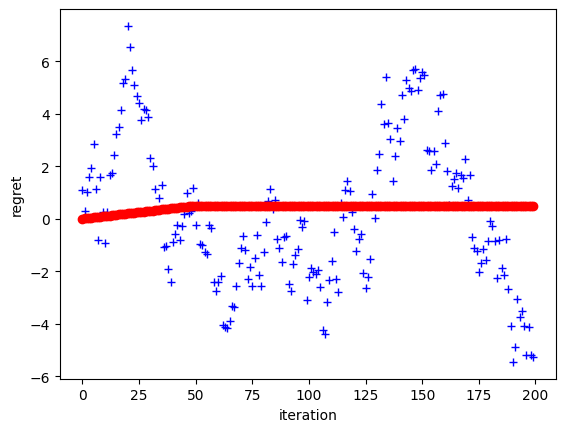

Optimal action: 2


In [235]:
# Try it with two arms and small difference between the mean values
k = 2
means = [0.53, 0.54]
m = 50
rounds = 200
experiment_etc(k, means, m, rounds)
# What are the required number of rounds to find the best action?
# Generally, the required number of rounds depends on the balance between m and the number of rounds.
# Contrary to UCB (Which will be discussed later), ETC balances exploration and exploitation using 
# the choice of m (number of expliration rounds per arm) and the total number of rounds.
# In this case, we reach convergence of the expected regret (red) after 50 iterations, meaning ETC
# has choosen a promising action at that point. 100 or 150 iterations would be enough in this case.
# It should be noted however, that this question depends largely on other aspects as well: 
# Variablility in rewards, desired confidence level, cost of exploration, as well as difference in
# means and number of arms, which we will subsequently explore.

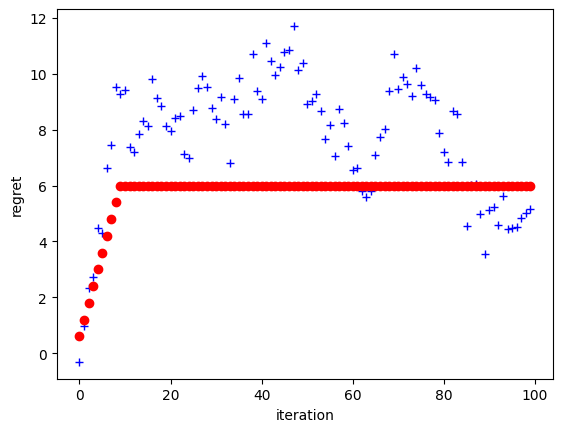

Optimal action: 2


In [260]:
# Try it with two arms and big difference between the mean values
k = 2
means = [0.2, 0.8]
m = 10
rounds = 100
experiment_etc(k, means, m, rounds)
# What are the required number of rounds to find the best action?
# If the difference in means of the arms is large, less exploration is typically 
# needed to identify the best arm with high confidence. For that reason I decreased
# exploration to 10% of total rounds, instead of the previous 25% with close means.
# A clear convergence can be seen after the initial exploration phase, leading me
# to believe, that this is a good choice.
# The additional aspects from the first ETC answer should still be considered.

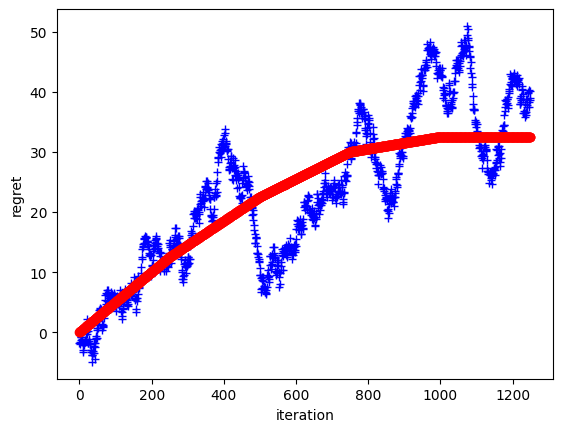

Optimal action: 2


In [264]:
# Try it with five arms and small differences among the mean values
k = 5
means = [0.52, 0.53, 0.54, 0.56, 0.57]
m = 250
rounds = 1000
experiment_etc(k, means, m, rounds)
# What are the required number of rounds to find the best action?
# Exploration is increased to 25% of total rounds again, while also significantly
# increasing the total rounds itself. Given the plot this looks like a good choice.
# The additional aspects from the first ETC answer should still be considered.

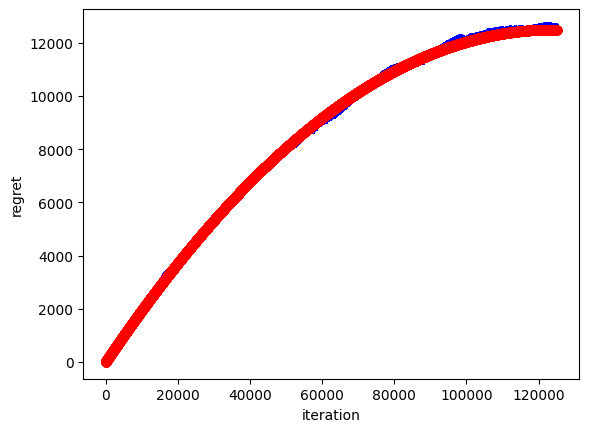

Optimal action: 50


In [265]:
# Try it with fifty arms and small differences among the mean values
k = 50
start = 0.4
end = 0.6
step = (end - start) / (k - 1)
means = np.arange(start, end + step, step)[:-1]
m = 2500
rounds = 25000
experiment_etc(k, means, m, rounds)
# What are the required number of rounds to find the best action?
# Similar setup as before, again reaching a nice plateau towards the end.
# The additional aspects from the first ETC answer should still be considered.

### UCB use-cases

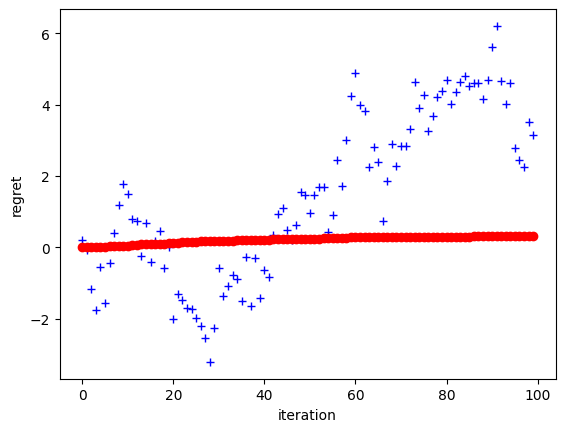

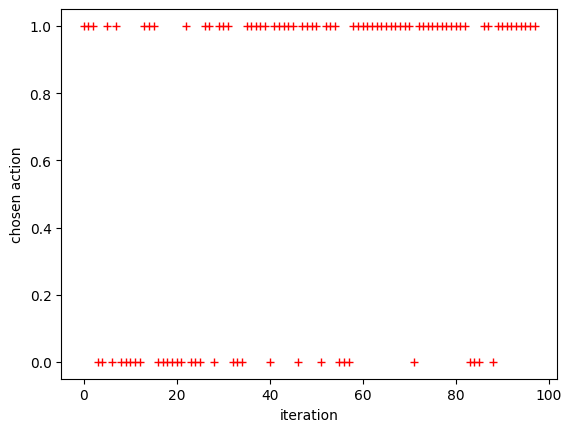

In [48]:
# Try it with two arms and small difference between the mean values
k = 2
means = [0.53, 0.54]
delta = 0.05
rounds = 100
experiment_ucb(k, means, delta, rounds)
# What are the required number of rounds to find the best action?
# This depends on the variance of the reward distributions and the difference in their means.
# Since the expected regret plot (red) stabilizes quickly, it suggests that not many rounds
# are needed for this specific setup to identify the best action with a high level of confidence.
# The chosen action plot shows action 1 with increasingly, towards the end of the 100 iterations.
# In this case I would already be confident with about 80 iterations.
# To select the best action, more factors should be considered, next to the frequency of each action.
# Eg.: Average rewards per arm or UCB Score.

# How the result changes with delta?
# Generally, changing delta in a UCB algorithm will affect how much the algorithm values exploration
# over exploitation. A smaller delta value will make the algorithm more conservative, preferring to
# exploit the current best-known option, while a larger delta encourages more exploration. This would
# affect both plots: with a higher delta, you would expect to see more variability in the regret over
# time (with potentially higher peaks indicating more exploration) and less consistent selection of a
# single action in the action plot, especially in the early rounds.
# Thus with higher delta, more iterations would be needed to settle on one action.

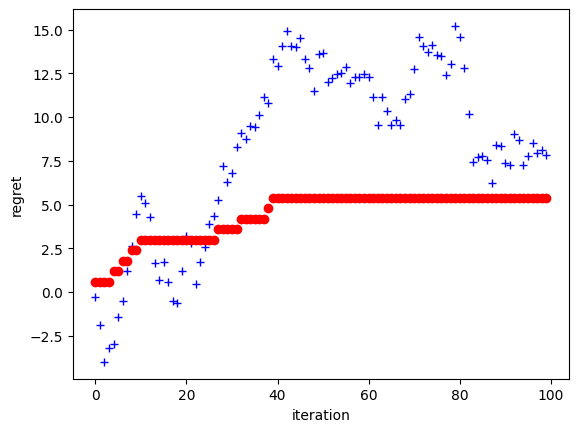

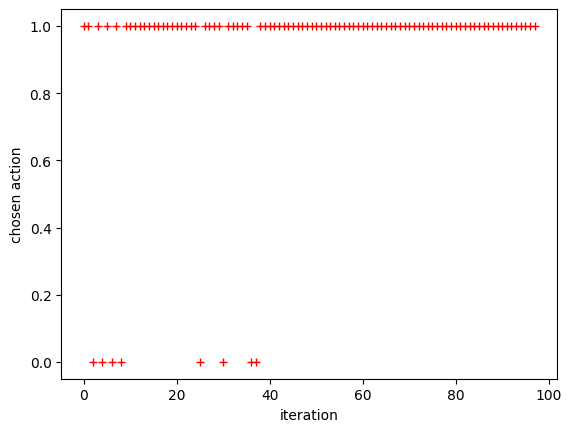

In [12]:
# Try it with two arms and big difference between the mean values
k = 2
means = [0.2, 0.8]
delta = 0.05
rounds = 100
experiment_ucb(k, means, delta, rounds)
# What are the required number of rounds to find the best action?
# Here the algorithm clearly converges after about 40 iterations. It is also very confident about
# choosing action one, so I believe not much more than 40 iterations would be needed in this case.
# The additional aspects from the first UCB answer should still be considered.

# How the result changes with delta?
# The general idea is similar to the first UCB answer. In this particular case, the algorithm remains
# confident about choosing the first action.

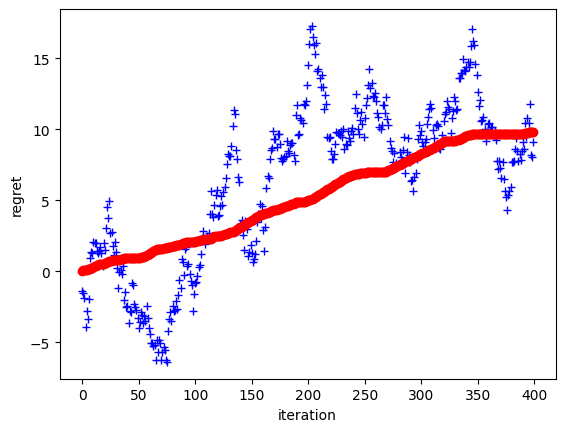

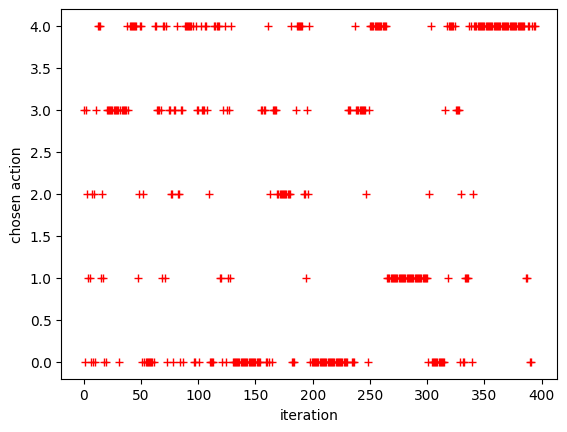

In [62]:
# Try it with five arms and small differences among the mean values
k = 5
means = [0.52, 0.53, 0.54, 0.56, 0.57]
delta = 0.05
rounds = 400
experiment_ucb(k, means, delta, rounds)
# What are the required number of rounds to find the best action?
# In this case a few more iterations were needed to reach a convergence on action four.
# A plateau can be seen in the expected regret (red) after around 350 iterations. I would
# recommend performing the 400 iterations I suggested here, to reach this consus.
# The additional aspects from the first UCB answer should still be considered.

# How the result changes with delta? 
# Here the changing the delta noticably impacts the exploration/exploitation trade-off,
# which leads to necessary adjustments in iterations until a viable action can be selected.

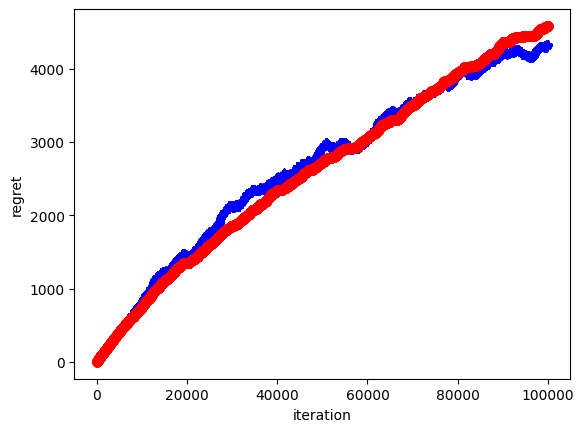

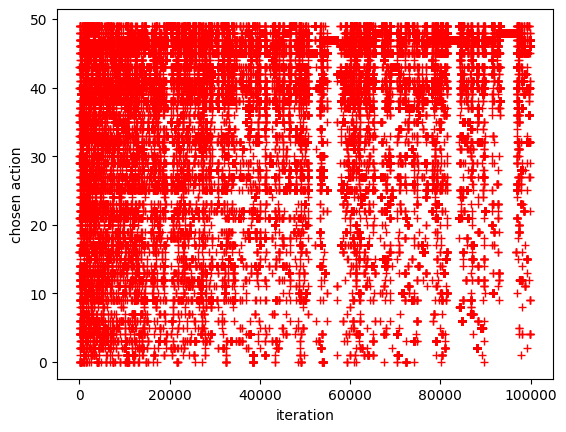

In [110]:
# Try it with fifty arms and small differences among the mean values
k = 50
start = 0.4
end = 0.6
step = (end - start) / (k - 1)
means = np.arange(start, end + step, step)[:-1]
delta = 0.001
rounds = 1e5
experiment_ucb(k, means, delta, rounds)
# What are the required number of rounds to find the best action?
# After around 90k iterations, we can see a plateau. The plot around chosen actions confirms this 
# with fifty becoming the overarching choice.
# The additional aspects from the first UCB answer should still be considered.

# How the result changes with delta?
# Here I deliberately decreased the delta, to reduce exploration and encourage exploitation in order
# to reduce the iterations needed until a convergence of the expected regret (red).